In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from mod_opt.data_load import *

#### functions

In [3]:
import matplotlib.pyplot as plt
import ast
from sklearn.metrics import r2_score, mean_squared_error

def get_hyperparam_feat(df, index=0):
    '''
    Function to return hyperparameter config and selected features from dataframe of scores
    index =0 mean the hyperparameter for the highet r2_adj
    '''
    # Get the column names
    column_names = df.columns.tolist()

    # Find the index of 'r2_train'
    r2_train_index = column_names.index('num_features')

    # Select every column before 'r2_train'
    selected_columns = df.iloc[:, :r2_train_index]

    # Convert the DataFrame to a dictionary
    result_dict = selected_columns.to_dict('index')

    # Get the id of the best hyperparameter
    id = df.sort_values(by='r2_adj',ascending=False).index[index]

    # Get feature
    if type(df['selected_features'][id]) == str:
        df['selected_features'] = df['selected_features'].apply(ast.literal_eval)
    feat = df['selected_features'][id]
    return result_dict[id], feat

def plot_with_flight_num(predicted, actual, labels, title, plot_number=True, save_fig=None):

    # Extract the 'Flight' column
    flight_column = labels['Flight']
    plot_column = labels['Plot']

    # Get unique flight numbers
    unique_flights = flight_column.unique()

    # Define a color map to assign a unique color to each flight
    color_map = plt.get_cmap('turbo', len(unique_flights))
    #color_map = plt.get_cmap('Paired', len(unique_flights))

    # Sort unique_flights in ascending order
    unique_flights = np.sort(unique_flights)

    # Create scatter plots for each feature, distinguishing flights by color
    plt.figure(figsize=(8, 6))

    for i, flight_number in enumerate(unique_flights):
        mask = flight_column == flight_number
        # Check the starting characters of the flight number and change the marker accordingly
        if str(flight_number).startswith('2021'):
            marker = 'o'  # circle
        elif str(flight_number).startswith('2022'):
            marker = '^'  # triangle
        elif str(flight_number).startswith('2023'):
            marker = 'x'  # x

        plt.scatter(actual[mask], predicted[mask], s=100, alpha=1, label=f'{flight_number}', color=color_map(i/len(unique_flights)), marker=marker)

    if plot_number:
        # Add plot numbers as text labels
        for i,plot_num in enumerate(plot_column):
                plt.text(actual.iloc[i], predicted[i], f'{plot_num}', fontsize=10, ha='right')  
            
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--')
    plt.xlabel('Actual DS (%)', fontsize=18)
    plt.ylabel('Predicted DS (%)', fontsize=18)
    plt.title(title, fontsize=18)
    plt.legend(loc = 'upper left', ncol=3)
    plt.grid()
    plt.tick_params(axis='both', which='major', labelsize=16)  # Increase tick size
    plt.tight_layout()
    if save_fig:
        plt.savefig(save_fig)
    plt.show()

def model_evaluate2(model, feat, labels, title, plt_num=True, save_fig=None):
    print('Train score: ',model.score(X_train_norm[feat],y_train), ' RMSE:',mean_squared_error(y_train, model.predict(X_train_norm[feat]), squared=False))
    print('Validation score: ',model.score(X_val_norm[feat],y_val), ' RMSE:',mean_squared_error(y_val, model.predict(X_val_norm[feat]), squared=False))
    print('Test score: ',model.score(X_test_norm[feat],y_test), ' RMSE:',mean_squared_error(y_test, model.predict(X_test_norm[feat]), squared=False))

    plot_with_flight_num(model.predict(X_test_norm[feat])*100,y_test*100,labels, title=title, plot_number=plt_num,save_fig=save_fig)


## RF

Train score:  0.8936308653091674  RMSE: 0.06923516415670579
Validation score:  0.870722343123187  RMSE: 0.08094402100116532
Test score:  0.8212898350870208  RMSE: 0.09307135641089022


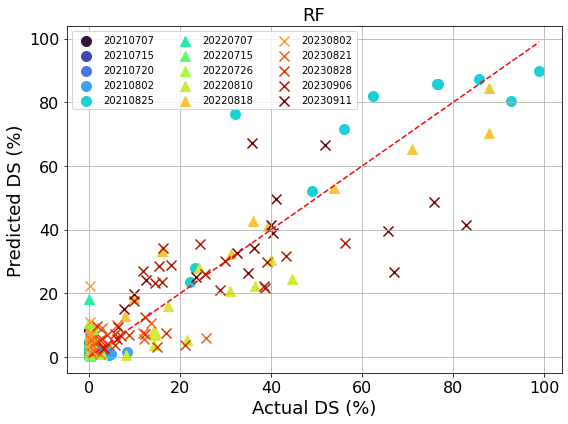

In [5]:
from sklearn.ensemble import RandomForestRegressor

result_rf = pd.read_csv('mod_opt/model_scores/rf_scores_mfs.csv',index_col=0,header=0)
hyperparameters, feat = get_hyperparam_feat(result_rf, index=0)

model = RandomForestRegressor(**hyperparameters).fit(X_train_norm[feat],y_train)
model_evaluate2(model, feat, labels_test, title='RF', plt_num=False)#, save_fig='figures/RF_test.png')

## XGBoost

Train score:  0.9250440377961859  RMSE: 0.05811951812777224
Validation score:  0.8856709010695105  RMSE: 0.0761204643777621
Test score:  0.8078434381045663  RMSE: 0.09650926882920632


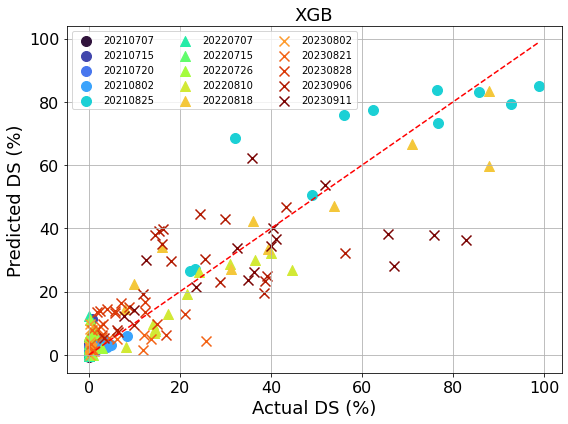

In [8]:
import xgboost as xgb

result_xgb = pd.read_csv('mod_opt/model_scores/xgb_scores_mfs.csv',index_col=0,header=0)
hyperparameters, feat = get_hyperparam_feat(result_xgb, index=0)

model = xgb.XGBRegressor(**hyperparameters).fit(X_train_norm[feat],y_train)
model_evaluate2(model, feat,labels_test, title='XGB', plt_num=False)#, save_fig='figures/XGB_test.png')

## SVR

Train score:  0.8750461438037025  RMSE: 0.0750401588679102
Validation score:  0.8067473699418808  RMSE: 0.09896593800694084
Test score:  0.7822844651365088  RMSE: 0.10272735943867563


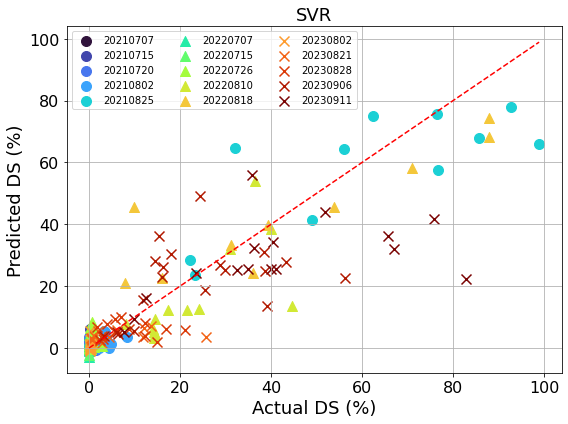

In [9]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

result_svr = pd.read_csv('mod_opt/model_scores/svr_scores_cfs.csv',index_col=0,header=0)
hyperparameters, feat = get_hyperparam_feat(result_svr, index=0)

model = SVR(**hyperparameters).fit(X_train_norm[feat],y_train)
model_evaluate2(model, feat, labels_test, title='SVR', plt_num=False)#, save_fig='figures/SVR_test.png')

## PLSR

Train score:  0.763189071371279  RMSE: 0.10330462928085933
Validation score:  0.827123630166636  RMSE: 0.09360323443318556
Test score:  0.7865165505555299  RMSE: 0.10172402156213439


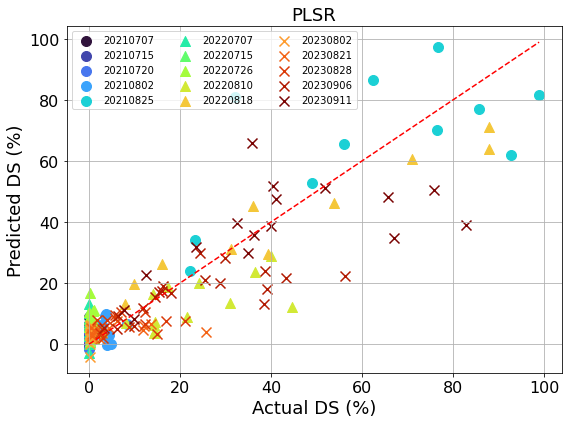

In [13]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error

result_plsr = pd.read_csv('mod_opt/model_scores/plsr_scores_cfs.csv',index_col=0,header=0)
hyperparameters, feat = get_hyperparam_feat(result_plsr, index=0)
hyperparameters ={'n_components': 5} # to avoid n_component > n_feature error
model = PLSRegression(**hyperparameters).fit(X_train_norm[feat],y_train)
model_evaluate2(model, feat, labels_test, title='PLSR', plt_num=False)#, save_fig='figures/PLSR_test.png')